<a href="https://colab.research.google.com/github/JoshKonoff/fine_tuning_efficientnetDB/blob/main/Transfer_Learning2_FineTuning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TF - Fine Tuning

In [2]:
#Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. 
#This fine-tuning usually takes more data than feature extraction to be effective.

In [3]:
### What we'll work on in this notebook:
#1. The Keras Functional API: (a differnt way to build models in Keras)
#2. Data augmentation (make your model more diverse without adding more data)
#3. Save intermediate results with the ModelCheckpoint callback
#4. Compare results of different models using TensorBoard

In [4]:
!nvidia-smi

Wed Jul 28 13:13:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Get helper_functions.py script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-28 13:13:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-28 13:13:12 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
###Get the raw data. Otherwise error: https://stackoverflow.com/questions/37818409/strange-html-doctype-error-when-trying-to-run-python-script-from-bash

In [7]:
#Import specific helper functions to use:
#Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [8]:
# Let's use the tf.keras.applications model with our smaller (10% dataset)

# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-07-28 13:13:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   207MB/s    in 0.8s    

2021-07-28 13:13:15 (207 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [9]:
#Walk through 10 percent data director and list number of files
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [10]:
#We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images

In [11]:
###import pathlib - unnecessary for this notebook - note for previous
#import numpy as np

#data_dir = pathlib.Path('pizza_steak/train')
#class_names = np.array(sorted([item.name for item in data_dir.glob('*')][1:])) 
#data_dir is a path
#data_dir isn't iteratable 
#print(type(data_dir)) 

#print(class_names)

In [12]:
#Create training and test directories
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test/'

In [13]:
###Previously we used the ImageDataGenerator class. Even though this still works well we're going to...
### use the much better image_data_from_directory function

In [14]:
#tf.keras.preprocessing.image_dataset_from_directory() is much faster than ImageDataGenerator

In [15]:
import tensorflow as tf
IMG_SIZE = (224,224) #define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [16]:
#Check the training data datatype
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [17]:
#In the above output:

#(None, 224, 224, 3) refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
#(None, 10) refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).
#Both image tensors and labels are of the datatype tf.float32.

##The batch_size is None due to it only being used during model training. You can think of None as a placeholder waiting to be filled with the batch_size parameter from image_dataset_from_directory().

##Another benefit of using the tf.data.Dataset API are the assosciated methods which come with it.

##For example, if we want to find the name of the classes we were working with, we could use the class_names attribute.
#t

In [18]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [19]:
#Or if to see an example batch of data, we could use the take() method.

#See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images[0][0],labels[0][0])

tf.Tensor(
[[180.93878  138.93878  100.938774]
 [183.2296   139.2296   102.22959 ]
 [184.91325  138.91325  104.91327 ]
 [183.67857  137.67857  103.678566]
 [182.57652  138.14796  102.80102 ]
 [183.40816  140.21428  100.81122 ]
 [174.7449   133.33163   90.84694 ]
 [181.92859  131.64287   89.35714 ]
 [180.09184  130.28572   87.28571 ]
 [185.64284  137.07143   95.85714 ]
 [180.96428  133.46428   92.46429 ]
 [184.28061  134.70918   97.06633 ]
 [181.02551  129.0255    92.025505]
 [179.22449  126.5102    89.86735 ]
 [187.52553  130.83675   98.066345]
 [193.37245  138.56633  102.39796 ]
 [183.19388  131.12755   90.48469 ]
 [179.21428  129.85715   87.85714 ]
 [183.80104  135.86226   97.15818 ]
 [181.92857  135.85715  103.071434]
 [178.65816  133.7857   106.188774]
 [174.82652  134.15817  106.31122 ]
 [169.40306  124.5204    91.66835 ]
 [177.35715  129.92857   87.71428 ]
 [169.35712  123.49999   76.642845]
 [166.93877  128.08163   80.714294]
 [161.43367  134.38776   88.887764]
 [150.69894  132.

#Building our transfer learning model using the Keras Functional API

#Alright, our data is tensor-ified, let's build our model

#To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

#Steps:
1. Intantiate a pre-trained base model such as EfficientNetB from tf.keras.applications
   setting the include_top parameter to False (we do this b/c we're going to create our own top, which are the output layers for the model)
2. Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model
3. Define an input layer for our model, for example, waht shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if required. Some computer vision models
   such as ResNetV250 require their inputs to be between 0 & 1
   EfficientNet automatically normalizes!   

In [20]:
#Pass the inputs to the base model.
#Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
#Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
#Combine the inputs and outputs layer into a model using tf.keras.Model().
#Compile the model using the appropriate loss function and choose of optimizer.
#Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [21]:
#1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

#3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224, 3), name='input_layer')

#4. If using ResNet this is where you'd normalize
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5 Pass the inputs to the base_model
x= base_model(inputs)
# Check data shape after passing it to the base_model
print(f'Shape after base_model: {x.shape}') ###

#6. Average pool the outputs of the base model 
#(aggregate all the most important, reducing number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'After GlobalAveragePooling(): {x.shape}')

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster
                                 #We want faster experiments!
                                 validation_steps=int(0.25 * len(test_data_10_percent)
                                 ),
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])



16711680/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210728-131323
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 277ms/step - loss: 1.8686 - accuracy: 0.4280 - val_loss: 1.3358 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 4s 163ms/step - loss: 1.1307 - accuracy: 0.7507 - val_loss: 0.9120 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 5s 186ms/step - loss: 0.8459 - accuracy: 0.8000 - val_loss: 0.7514 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6831 - accuracy: 0.8333 - val_loss: 0.6751 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 5s 186ms/step - loss: 0.5857 - accuracy: 0.8613 - val_loss: 0.6103 - val_accuracy: 0.8224


In other words, we passed our custom data to an already pre-trained model (EfficientNetB0), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. Keras Functional API is more efficient

In [22]:
#https://www.tensorflow.org/guide/keras/functional
# Check layers in our base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)   #layer.name

  ####layer_number[0:50]

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [23]:
#To hardcode all these layers would take a lot of time.
#Yet we can still take advantage of them thanks to the power of transfer learning

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set base_model.trainable = False, these patterns remain as they are during training (they're frozen and don't get updated).

In [24]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________



Our overall model has five layers but really, one of those layers (efficientnetb0) has 236 layers.

You can see how the output shape started out as (None, 224, 224, 3) for the input layer (the shape of our images) but was transformed to be (None, 10) by the output layer (the shape of our labels), where None is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

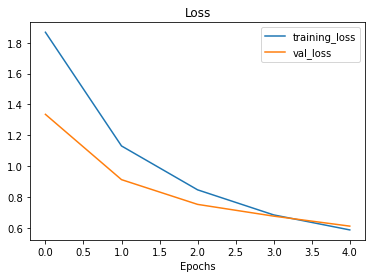

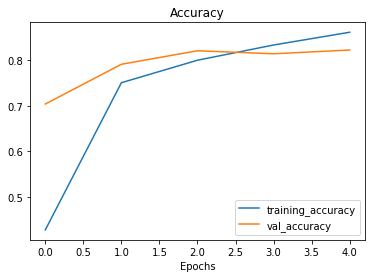

In [25]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

In [26]:
### Very good resource: https://www.youtube.com/watch?v=71mubTQ90Uw (GlobalAveragePooling)

In [27]:
# S   Running a series of transfer learning experiments

#Let's run and compare these experiments

model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.

model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.

model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [28]:
###To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

In [29]:
### Instead of using ImageDataGenerator we'll use tf.keras.layers.experimental.preprocessing

In [30]:
#Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

#Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

--2021-07-28 13:14:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   236MB/s    in 0.5s    

2021-07-28 13:14:30 (236 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [31]:
#How many images are we working with in the 1 percent directories?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [32]:
#Looks like we're got 7 images for each class (training). This should be quite a challenge for our model.
#Our test set stays the same -- still 250 images

In [33]:
#Time to load in our images
#We'll use the .image_dataset_from_directory() method to load the images

import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Data loaded. Time to augment it

In [34]:
###ImageDataGenerator -----> tf.keras.layers.experimental.preprocessing
#Images are processing on the GPU instead of the CPU

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [36]:
#We'll be able to use this data augmentation Sequential model later as a layer into our transfer learning model!

In [37]:
####Got this error: https://careerkarma.com/blog/python-syntaxerror-cant-assign-to-function-call/

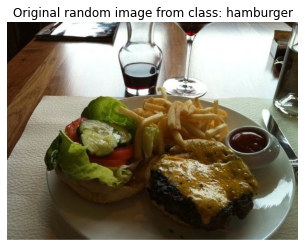

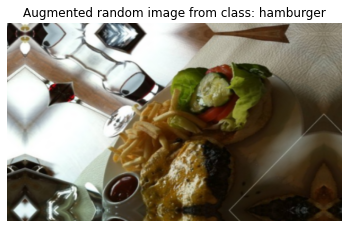

In [38]:
## View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

**Model 1: Feature extraction transfer learning on 1% of the data with data augmentation**

In [39]:
###Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
input = layers.Input(shape=input_shape, name='input_layer')

#Add in data augmentation Sequential model as a layer
x= data_augmentation(inputs)

#Give base_model inputs (after augmentation) and don't train it
x=base_model(x, training=False)

#Pool output features of base model
x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

#Put a dense layer on as the output
outputs=layers.Dense(10, activation='softmax', name='ourput_layer')(x)

#Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

#Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Fit the model

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)), #validate for less to speed up
                                #Track model training logs
                                callbacks=[create_tensorboard_callback('transfer_learning', '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210728-131435
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 10s 2s/step - loss: 2.4128 - accuracy: 0.1286 - val_loss: 2.3273 - val_accuracy: 0.1217
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1792 - accuracy: 0.2143 - val_loss: 2.2025 - val_accuracy: 0.1974
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9601 - accuracy: 0.4286 - val_loss: 2.0833 - val_accuracy: 0.2664
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8395 - accuracy: 0.4857 - val_loss: 1.9879 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6241 - accuracy: 0.6571 - val_loss: 1.8988 - val_accuracy: 0.4260


There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.


The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line validation_steps=int(0.25 * len(test_data)). Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

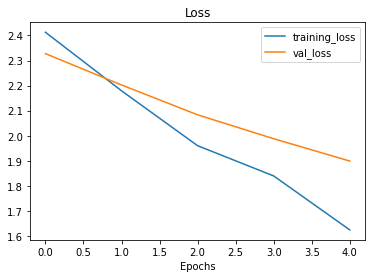

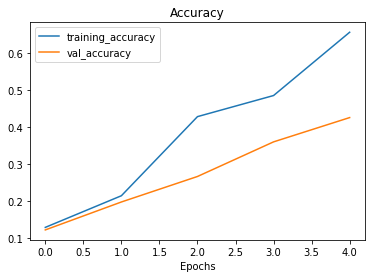

In [40]:
plot_loss_curves(history_1_percent)

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

In [41]:
###Let's run the exact same experiment on 10% of data

In [42]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [43]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.



Awesome! We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [44]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
###This time before we fit let's create a ModelCheckpoint callback
#ModelCheckpoint let's you save your model as a whole in the SavedModel format 
#or the weights (patterns only)
###This is helpful if you think your model is going to be training for a long time and you
#want to make backups of it as it trains

###it also lets you continue training from a specific epoch.
#for example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves
#and see it is still improving and want to see if fine-tuning for another 5 epochs could help. 
#You can load the ModelCheckpoint#unfreeze some (or all) of the base modell layers and then continue training

#This is exactly what we're going to do

In [46]:
###To create a ModelCheckpoint callback: we have to specifcy a directory we'd like to save to.

In [47]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable initial_epochs and set it to 5 to use later.

We'll also add in our checkpoint_callback in our list of callbacks.

In [48]:
#Fit the model saving checkpoints every epoch

initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          #do less steps per validation (quicker)
                                          
                                          callbacks=[create_tensorboard_callback('transferlearning', '10_percent_data_aug'),
                                                     checkpoint_callback]
                                          )

Saving TensorBoard log files to: transferlearning/10_percent_data_aug/20210728-131501
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 383ms/step - loss: 2.0332 - accuracy: 0.3120 - val_loss: 1.5235 - val_accuracy: 0.6414

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 6s 237ms/step - loss: 1.3696 - accuracy: 0.6627 - val_loss: 1.1039 - val_accuracy: 0.7500

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 6s 251ms/step - loss: 1.0787 - accuracy: 0.7587 - val_loss: 0.9012 - val_accuracy: 0.7862

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 6s 227ms/step - loss: 0.9255 - accuracy: 0.7653 - val_loss: 0.8123 - val_accuracy: 0.7780

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 6s 238ms/step - loss: 0.8128 - accuracy: 0.7880 - val_loss

Would you look at that! Looks like our ModelCheckpoint callback worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights).

Let's evaluate our model and check it's loss curves.

In [49]:
###Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 88ms/step - loss: 0.6975 - accuracy: 0.8164


[0.6975372433662415, 0.8163999915122986]

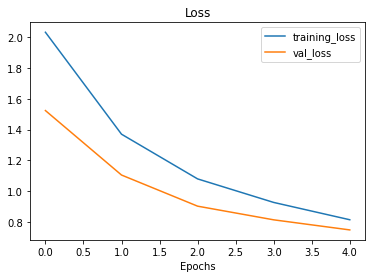

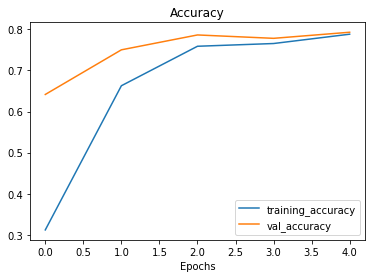

In [50]:
#Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the load_weights() method, passing it the path where your saved weights are stored.

In [51]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.6975 - accuracy: 0.8164


In [52]:

import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

**Model 3: Fine-tuning an existing model on 10% of the data**

High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

In [53]:
### Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out

In [54]:
#Layers in loaded model
model_2.layers

In [55]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


#We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetB0), a pooling layers and a Dense layer (the output layer)

In [56]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [57]:
#How many layers in our base model (EfficientNet) are trainable?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [58]:
#This is the same as our base model
print(len(base_model.trainable_variables))

0


In [59]:
#Let's check layer by layer
### Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

#Let's unfreeze the top 10 layers and continue training our model for another 5 epochs

#This means all of the base model's layers except for the last 10 will remain frozen and untrainable
#The weights in the remaining unfrozen layers will be updated during training

#Ideally, we should see the models performance improve.

#Generally the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune

In [60]:
###To begin fine-tuning, we'll unfreeze the entire base model by setting it's trainable attribute to True
#Then we'll loop through and freeze all except the last 10!

In [61]:
base_model.trainable = True

#Freeze all layers except for the last 10:
for layer in base_model.layers[:-10]: #don't grab the last 10
  layer.trainable = False

# Recompile the model (always recompile after any adjustment to a model)
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), #lr is 10x lower than before fine tuning
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [62]:
#Now check which layers are trainable

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Nice! We made the last 10 layers trainable. All the other layers are untrainable and stil frozen 
This means that only the last 10 layers of the base model along with the output layer will have their weights updated during training

In [63]:
###base_model = tf.keras.applications.EfficientNetB0(include_top=False)  ### defined above
###base_model.trainable = False

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

🔑 Note: There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

In [64]:
#How many trainable variables do we have now?


print(len(model_2.trainable_variables))

#Wonderful, it looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

12


In [65]:
#Wonderful, it looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

#Time to fine-tune!

In [66]:
######We're going to continue training on from where our previous model finished. 
######Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

In [67]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as the model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    initial_epoch=history_10_percent_data_aug.epoch[-1],
                                                    ###start from the previous last epoch
                                                    validation_steps=int(0.25 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_fine_tune_last_10')]) #name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210728-131602
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 348ms/step - loss: 0.6801 - accuracy: 0.8107 - val_loss: 0.5999 - val_accuracy: 0.8125
Epoch 6/10
24/24 [==============================] - 6s 256ms/step - loss: 0.5571 - accuracy: 0.8373 - val_loss: 0.5605 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 6s 221ms/step - loss: 0.4838 - accuracy: 0.8640 - val_loss: 0.5373 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 5s 208ms/step - loss: 0.4584 - accuracy: 0.8667 - val_loss: 0.5370 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 5s 208ms/step - loss: 0.3889 - accuracy: 0.8773 - val_loss: 0.5648 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 6s 249ms/step - loss: 0.4071 - accuracy: 0.8707 - val_loss: 0.5203 - val_accuracy: 0.8306


In [68]:
##Looks like our model has gained a few percentage points of accuracy! Let's evaluate it
#Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.4904 - accuracy: 0.8380



Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [69]:
#####

from matplotlib import *
import sys
from pylab import *

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


This is where saving the history variables of our model training comes in handy. Let's see what happened after fine-tuning the last 10 layers of our model.

5
11
[0.31200000643730164, 0.6626666784286499, 0.7586666941642761, 0.765333354473114, 0.7879999876022339, 0.8106666803359985, 0.8373333215713501, 0.8640000224113464, 0.8666666746139526, 0.8773333430290222, 0.8706666827201843]


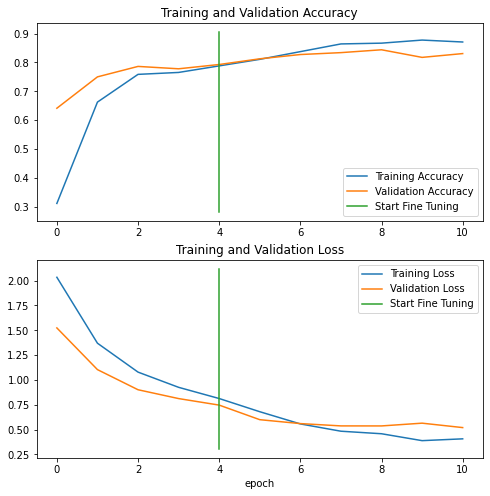

In [70]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [71]:
#Our model is heading in the right direction but...
## Remember that fine tunning usually works best with larger amounts of data

Model 4: What happens when we Fine-tune on all the data?

In [72]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2021-07-28 13:26:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   259MB/s    in 1.9s    

2021-07-28 13:26:29 (259 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [73]:
# Setup data directories
train_dir = '/content/10_food_classes_all_data/train'
test_dir = '/content/10_food_classes_all_data/test'

In [74]:
###How many images are we now working with:
walk_through_dir('/content/10_food_classes_all_data')

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/test'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/hamb

In [75]:
### And now we'll turn the images into tensor dataset!!! ###

import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE,
                                                                                 batch_size=BATCH_SIZE)

#Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
####Our data is currently fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data
#and keep our experiments consisten, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [81]:
is_it_close =model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.4904 - accuracy: 0.8380


In [82]:
np.isclose(np.array(is_it_close), np.array(results_fine_tune_10_percent))

array([ True,  True])


Alright, the previous steps might seem quite confusing but all we've done is:

Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
Saved the results and training logs each time.
Reloaded the model from 1 to do the same steps as 2 but with all of the data.
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [83]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [90]:
#### Let's get more specific and look specifically inside the EfficientNet layer
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)   #### print out the last 20 layers

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Looking good! The last 10 layers are trainable (unfrozen)

Since we adjusted our model we need to recompile it

In [91]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210728-135407
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 35s 147ms/step - loss: 0.6623 - accuracy: 0.7883 - val_loss: 0.4109 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 32s 134ms/step - loss: 0.5603 - accuracy: 0.8200 - val_loss: 0.3642 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 31s 131ms/step - loss: 0.5049 - accuracy: 0.8383 - val_loss: 0.3522 - val_accuracy: 0.8717
Epoch 8/10
235/235 [==============================] - 31s 130ms/step - loss: 0.4640 - accuracy: 0.8463 - val_loss: 0.3508 - val_accuracy: 0.8766
Epoch 9/10
235/235 [==============================] - 31s 129ms/step - loss: 0.4349 - accuracy: 0.8629 - val_loss: 0.3409 - val_accuracy: 0.8898
Epoch 10/10
235/235 [==============================] - 30s 124ms/step - loss: 0.4110 - accuracy: 0.8677 - val_loss: 0.3164 - val_accuracy: 0.8914


In [92]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 87ms/step - loss: 0.3135 - accuracy: 0.8988


[0.3135031759738922, 0.8988000154495239]

In [93]:
#Nice! Looks like fine-tuning with all of the data has given our model a boost.
#How do our training curves look?

5
11
[0.31200000643730164, 0.6626666784286499, 0.7586666941642761, 0.765333354473114, 0.7879999876022339, 0.788266658782959, 0.8199999928474426, 0.8382666707038879, 0.8462666869163513, 0.862933337688446, 0.867733359336853]


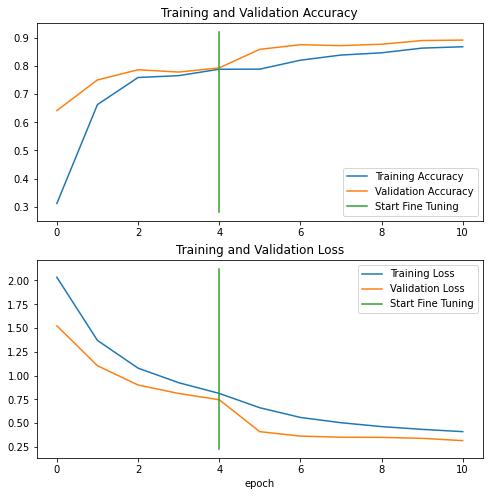

In [94]:
# How did fine-tuning do with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.


**Viewing our experiment data on TensorBoard**

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function create_tensorflow_callback(), we've been tracking our modelling experiments the whole time.

In [95]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2021-07-28 14:02:19.223109: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

In [96]:
# View previous experiments
#!tensorboard dev list

In [97]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q